In [1]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import linregress
from scipy.signal import convolve2d
from tqdm.notebook import tqdm

import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# 1. Загрузка данных

In [2]:
df_users = pd.read_csv('student_data/df_users.csv')
df_sales_raw = pd.read_csv('student_data/df_sales.csv')

# 2. Удаление выбросов и агрегация по дням

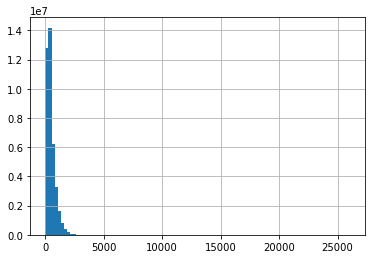

In [3]:
df_sales_raw['sales'].hist(bins=100);

In [4]:
df_sales_drop_outlier = df_sales_raw[df_sales_raw['sales'] <= 5000].copy()
df_sales = df_sales_drop_outlier.groupby(['user_id', 'day'])[['sales']].sum().reset_index()

# 3. Обучим модель прогнозировать недельные продажи

Будем по данным за последние 4 недели прогнозировать следующую недельную выручку.

In [5]:
def get_feature_target_trends(
    df_sales: pd.DataFrame, user_ids: np.array, days_x: np.array, days_y: np.array
):
    """Генерируем признаки, целевую метрику и тренд для целевой метрики / каждого пользователя.

    df_sales - датасет с данными о продажах
    user_ids - id клентов, для которых нужно сгенерить признаки
    days_x - дни, используемые для вычисления признаков. 4 недели.
    days_y - дни, используемые для вычисления таргета. 1 неделя, сразу после days_x.

    return:
        X - признаки,
        Y_for_predict - таргет с вычтенным трендом,
        Y_real - таргет без вычтенного тренда,
        add_y_trendpd - добавка тренда к таргеты
    """
    days = np.hstack([days_x, days_y])
    user_id_to_index = {user_id: idx for idx, user_id in enumerate(user_ids)}
    day_to_index = {day: idx for idx, day in enumerate(days)}
    
    # делаем матрице с продажами [user_id * day]
    array_sales = np.zeros((len(user_ids), len(days)))
    for user_id, day, sales in tqdm(df_sales[df_sales['day'].isin(days)][['user_id', 'day', 'sales']].values):
        array_sales[user_id_to_index[user_id], day_to_index[day]] = sales
        
    # сглаживаем на данных для признаков
    smooth_days = 14
    array_sales_smooth = convolve2d(
        array_sales[:, :len(days_x)],
        np.ones((1, smooth_days)) / smooth_days,
        'valid'
    )
    
    # cчитаем тренды
    x_ = np.arange(array_sales_smooth.shape[1])
    trends = np.array([linregress(x_, y)[0] for y in tqdm(array_sales_smooth)])
    # вычитаем тренды ToDO
    trend_matrix = np.ones((len(array_sales), 1)) * np.arange(len(days)) * trends.reshape(-1, 1)
    array_sales_drop_trend = array_sales - trend_matrix
    # что нужно будет добавить к Y
    add_y_trend = trend_matrix[:, -len(days_y):].sum(axis=1)
    
    # считаем таргет
    Y_for_predict = pd.Series(
        array_sales_drop_trend[:, -len(days_y):].sum(axis=1),
        index=user_ids
    )
    Y_real = pd.Series(
        array_sales[:, -len(days_y):].sum(axis=1),
        index=user_ids    
    )
    
    ##########################################################
    # считаем признаки
    dict_features = dict()
    
    # средние продажи за прошлые 4 недели
    for week in range(4):
        dict_features[f'mean_daily_sales_{week}_week'] = (
            array_sales_drop_trend[:, week * 7: (week + 1) * 7].mean(axis=1)
        )
        
    # продажи за прошлые 7 дня
    for last_day in range(1, 8):
        dict_features[f'daily_sales_day_minus_{last_day}'] = (
            array_sales_drop_trend[:, day_to_index[days_x[-last_day]]]
        )
        
    # кол-во дней с покупками
    dict_features['count_day_with_sales'] = (
        (array_sales[:, :len(days_x)] > 0).sum(axis=1)
    )
    # cумма стоимостей покупок
    dict_features['mean_sales_drop_trend'] = (
        array_sales_drop_trend[:, :len(days_x)].mean(axis=1)
    )
    # quantiles нормированная трата
    for quantile in [0, 0.2, 0.4, 0.6, 0.8, 1]:
        dict_features[f'sales_quantile_{quantile}'] = np.quantile(
            array_sales_drop_trend[:, :len(days_x)], quantile, axis=1
        )
    X = pd.DataFrame(dict_features, index=user_ids)
    return X, Y_for_predict, Y_real, add_y_trend


## 3.1. Cобираем данные

In [6]:
%%time


user_ids = df_users['user_id'].values


X_fit, Y_for_predict_fit, Y_real_fit, add_y_trend_fit = get_feature_target_trends(
    df_sales,
    user_ids,
    days_x=np.arange(14, 42),
    days_y=np.arange(42, 49)
)

X_test, Y_for_predict_test, Y_real_test, add_y_trend_test = get_feature_target_trends(
    df_sales,
    user_ids,
    days_x=np.arange(21, 49),
    days_y=np.arange(49, 56)
)


CPU times: user 7min 17s, sys: 7.68 s, total: 7min 24s
Wall time: 7min 23s


Разобъём данные для обучения на train и validation.

In [7]:
val_user_ids = np.random.choice(user_ids, int(len(user_ids) / 5), False)
train_user_ids = np.array(list(set(user_ids) - set(val_user_ids)))

X_val = X_fit.loc[val_user_ids]
X_train = X_fit.loc[train_user_ids]

y_val = Y_for_predict_fit.loc[val_user_ids]
y_train = Y_for_predict_fit.loc[train_user_ids]

## 3.2. Обучаем модель

In [8]:
gbm = lgb.LGBMRegressor(
    num_leaves=31,
    learning_rate=0.1,
    n_estimators=300
)
gbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='l1',
    early_stopping_rounds=5,
    verbose=False
)

LGBMRegressor(n_estimators=300)

In [9]:
predict_naive = Y_real_fit
predict_train = gbm.predict(X_fit) + add_y_trend_fit
predict_test = gbm.predict(X_test) + add_y_trend_test

score_train = mean_squared_error(Y_real_fit, predict_train)
score_test = mean_squared_error(Y_real_test, predict_test)
score_test_naive = mean_squared_error(Y_real_test, predict_naive)

corr_predict_fact = np.corrcoef(predict_test, Y_real_test)[0, 1]

print('scores:')
print(f'  test naive  = {score_test_naive:0.0f}')
print(f'  train       = {score_train:0.0f}')
print(f'  test        = {score_test:0.0f}')
print()
print(f'corr(predict_test, fact_test) = {corr_predict_fact:0.3f}')

scores:
  test naive  = 943607
  train       = 166283
  test        = 240909

corr(predict_test, fact_test) = 0.948


In [10]:
df_metrics = pd.DataFrame(
    {'sales': Y_real_test, 'sales_predict': predict_test},
    index=Y_real_test.index
)

# CUPED
covariance = np.cov(predict_train, Y_real_fit)[0, 1]
variance = np.var(predict_train)
theta = covariance / variance

df_metrics['sales_cuped'] = df_metrics['sales'] - theta * df_metrics['sales_predict']

df_metrics = df_metrics.sort_index()

## 3.3. Загружаем предсказания в файл с решением

In [11]:
# Преобразуем значения метрики в строку, которая будет читаться интерпритатором python как список.
# Округлим до целых значений, чтобы занимало меньше места в файле с решением.
# В файле с решением будет выглядеть так: "METRIC_VALUES = [123,43,22,...]"
list_metric_int = df_metrics['sales_cuped'].round().astype(int).to_list()
str_list_metric_int = json.dumps(list_metric_int, separators=(',', ':'))
line_metrics = f"METRIC_VALUES = {str_list_metric_int}\n"

# Прочитаем файл с шаблоном решения
with open('solution_.py', 'rb') as f:
    lines_solution_ = f.readlines()

# Заменим первую строку, запишем код решения в новый файл
with open('solution.py', 'wb') as f:
    f.write(line_metrics.encode())
    for line in lines_solution_[2:]:
        f.write(line)

In [12]:
ls -lh solution*.py

-rw-------@ 1 aleksandrsahnov  staff   4.1M Jul 17 11:55 solution.py
-rw-------@ 1 aleksandrsahnov  staff   6.1K Jul 17 11:40 solution_.py


In [13]:
!wc solution.py

     168     525 4328398 solution.py


In [14]:
!wc solution_.py

     169     543    6226 solution_.py
